In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
# import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# # Load a dataset into a Pandas DataFrame
# train_proteins = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
# train_peptides = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv")
# train_clinical = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")

# Load a dataset into a Pandas DataFrame
train_proteins = pd.read_csv("train_proteins.csv")
train_peptides = pd.read_csv("train_peptides.csv")
train_clinical = pd.read_csv("train_clinical_data.csv")
supplemental_clinical_data=pd.read_csv("supplemental_clinical_data.csv")

In [3]:
train_clinical

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
...,...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.0,Off
2611,65043_54,65043,54,4.0,8.0,11.0,1.0,Off
2612,65043_60,65043,60,6.0,6.0,16.0,1.0,Off
2613,65043_72,65043,72,3.0,9.0,14.0,1.0,Off


In [4]:
# Get the number of NaN values in each column
num_nans = train_clinical.isna().sum()

# Print the results
print(num_nans)

visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   1
updrs_2                                   2
updrs_3                                  25
updrs_4                                1038
upd23b_clinical_state_on_medication    1327
dtype: int64


## Combine data sets

In [5]:
# Function to prepare dataset with all the steps mentioned above:
def prepare_dataset(train_proteins, train_peptides):
    # Step 1: Grouping 
    df_protein_grouped = train_proteins.groupby(['visit_id','UniProt'])['NPX'].mean().reset_index()
    df_peptide_grouped = train_peptides.groupby(['visit_id','Peptide'])['PeptideAbundance'].mean().reset_index()
    
    # Step 2: Pivoting
    df_protein = df_protein_grouped.pivot(index='visit_id',columns = 'UniProt', values = 'NPX').rename_axis(columns=None).reset_index()
    df_peptide = df_peptide_grouped.pivot(index='visit_id',columns = 'Peptide', values = 'PeptideAbundance').rename_axis(columns=None).reset_index()
    
    # Step 3: Merging
    pro_pep_df = df_protein.merge(df_peptide, on = ['visit_id'], how = 'left')
    
    return pro_pep_df

In [6]:
pro_pep_df = prepare_dataset(train_proteins, train_peptides)

In [7]:
pro_pep_df

,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,8699_24,9983.00,400290.0,24240.10,NaN,16943.50,6303.17,77493.6,46435.3,254247.0,...,289888.0,8615.27,8770410.0,33599.1,926094.0,118897.0,133682.0,571879.0,80268.3,54889.70
1109,942_12,6757.32,360858.0,18367.60,14760.7,18603.40,1722.77,86847.4,37741.3,212132.0,...,173259.0,4767.63,374307.0,35767.3,250397.0,65966.9,77976.8,486239.0,45032.7,NaN
1110,942_24,NaN,352722.0,22834.90,23393.1,16693.50,1487.91,114772.0,36095.7,185836.0,...,185428.0,5554.53,NaN,64049.8,479473.0,68505.7,74483.1,561398.0,52916.4,21847.60
1111,942_48,11627.80,251820.0,22046.50,26360.5,22440.20,2117.43,82241.9,30146.6,167633.0,...,137611.0,6310.09,NaN,28008.8,231359.0,63265.8,64601.8,632782.0,51123.7,20700.30


In [8]:
# Get the number of NaN values in each column
num_nans = pro_pep_df.isna().sum()

# Print the results
print(num_nans)

visit_id                   0
O00391                   349
O00533                     1
O00584                    13
O14498                    81
                        ... 
YVNKEIQNAVNGVK             2
YWGVASFLQK                24
YYC(UniMod_4)FQGNQFLR      8
YYTYLIMNK                 83
YYWGGQYTWDMAK            248
Length: 1196, dtype: int64


## Fix NaN values

In [9]:
# fill nan with mean
pro_pep_df=pro_pep_df.fillna(pro_pep_df.mean())

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Define the degree of the polynomial features
degree = 5

# Loop over the columns to fill missing values
for col in ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']:
    # Create a copy of the dataframe
    df_copy = train_clinical.copy()
    df_copy_no_null = pd.concat([df_copy, supplemental_clinical_data], axis=0)
    df_copy_no_null = train_clinical.copy()
    df_copy_no_null=df_copy_no_null.dropna()

    # Drop rows where the target column has a missing value
    df_copy = df_copy.dropna(subset=[col])

    # Split the data into features and target
    X = df_copy[['visit_month']]
    y = df_copy[col]

    # Create polynomial features
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    # Train the model
    model = LinearRegression()
    model.fit(X_poly, y)

    # Loop over the rows to fill missing values
    for index, row in train_clinical.iterrows():
        if pd.isnull(row[col]):
            # Predict the missing value using the trained model
            X_pred = poly.fit_transform([[row['visit_month']]])
            y_pred = model.predict(X_pred)[0]

            # Fill in the missing value
            train_clinical.loc[index, col] = y_pred


In [11]:
# Replace NaN values with a placeholder value of -1
train_clinical['upd23b_clinical_state_on_medication'].fillna(-1, inplace=True)
# on will be labeled as 1 and off as 0
train_clinical['upd23b_clinical_state_on_medication'] = train_clinical['upd23b_clinical_state_on_medication'].replace({'Off': 0, 'On': 1})


In [12]:
# Get the number of NaN values in each column
num_nans = train_clinical.isna().sum()

# Print the results
print(num_nans)

visit_id                               0
patient_id                             0
visit_month                            0
updrs_1                                0
updrs_2                                0
updrs_3                                0
updrs_4                                0
upd23b_clinical_state_on_medication    0
dtype: int64


In [13]:
# round updrs_1	updrs_2	updrs_3	updrs_4 columns values to int then convert them in to int type columns
train_clinical['updrs_1'] = train_clinical['updrs_1'].apply(np.ceil).astype(int)
train_clinical['updrs_2'] = train_clinical['updrs_2'].apply(np.ceil).astype(int)
train_clinical['updrs_3'] = train_clinical['updrs_3'].apply(np.ceil).astype(int)
train_clinical['updrs_4'] = train_clinical['updrs_4'].apply(np.ceil).astype(int)


In [14]:
train_clinical

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10,6,15,3,-1
1,55_3,55,3,10,7,25,2,-1
2,55_6,55,6,8,10,34,2,-1
3,55_9,55,9,8,9,30,0,1
4,55_12,55,12,10,10,41,0,1
...,...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7,6,13,0,0
2611,65043_54,65043,54,4,8,11,1,0
2612,65043_60,65043,60,6,6,16,1,0
2613,65043_72,65043,72,3,9,14,1,0


C:\Users\gw\AppData\Local\Temp\ipykernel_18856\750604396.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = train_clinical.groupby(['visit_month']).mean().reset_index()


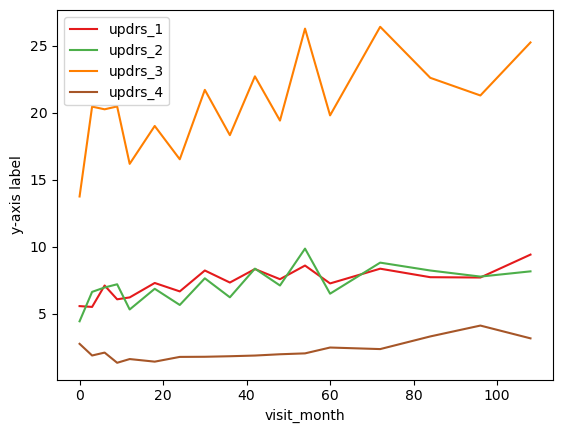

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset into a Pandas DataFrame
df = train_clinical.groupby(['visit_month']).mean().reset_index()

# Specify the x-axis column and the y-axis columns to plot
x_col = "visit_month"
y_cols = ["updrs_1", "updrs_2", "updrs_3","updrs_4"]

# Create a new figure and axis objects
fig, ax = plt.subplots()

# Plot each y-column against the x-column using a different color
for i, col in enumerate(y_cols):
    ax.plot(df[x_col], df[col], label=col, color=plt.cm.Set1(i/len(y_cols)))

# Add axis labels and legend
ax.set_xlabel(x_col)
ax.set_ylabel("y-axis label")
ax.legend()

# Show the plot
plt.show()


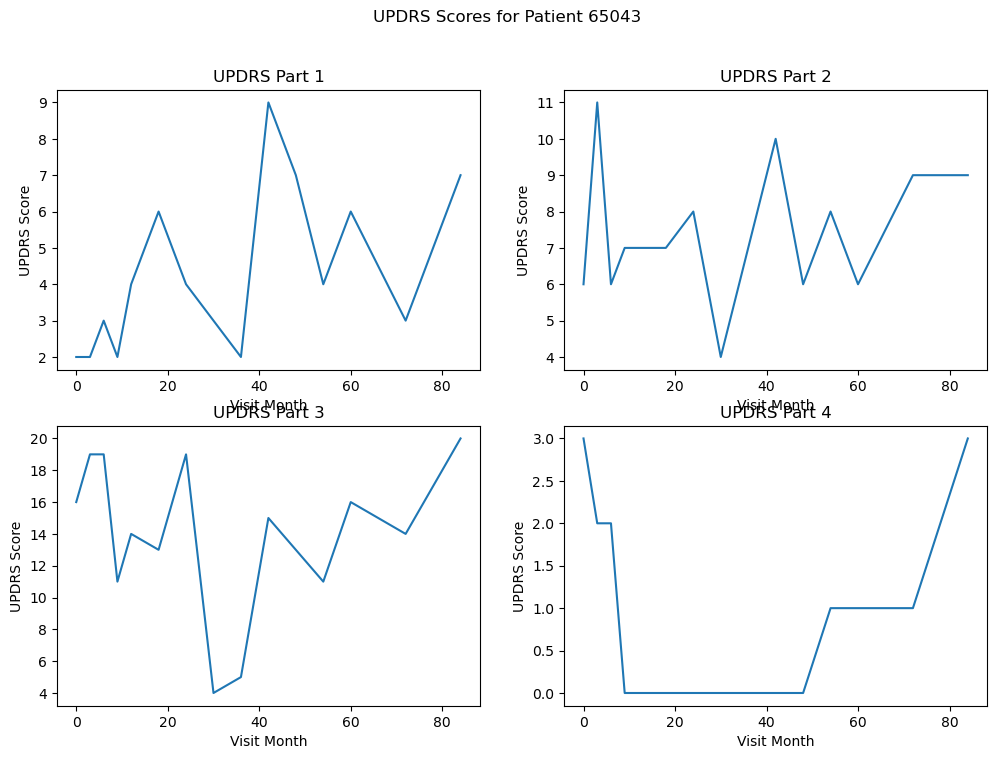

In [16]:
# set the patient id and filter the clinical data for that patient
patient_id = 65043
patient_data = train_clinical.loc[train_clinical['patient_id'] == patient_id]

# create a figure with subplots for each UPDRS score
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

# loop through each UPDRS score and plot against visit month
for i in range(4):
    axs[i].plot(patient_data['visit_month'], patient_data['updrs_'+str(i+1)])
    axs[i].set_xlabel('Visit Month')
    axs[i].set_ylabel('UPDRS Score')
    axs[i].set_title('UPDRS Part '+str(i+1))

# add a title to the figure
fig.suptitle('UPDRS Scores for Patient '+str(patient_id))

# show the figure
plt.show()

In [17]:
# merge pro_pep_df and train_clinical
merged_df = train_clinical.merge(pro_pep_df, on = ['visit_id'], how = 'left')

In [ ]:
# merged_df.to_csv('merged_df.csv', index=False)

In [19]:
merged_df

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,55_0,55,0,10,6,15,3,-1,11254.3,732430.0,...,201158.0,16492.3,3810270.0,106894.0,580667.0,131155.0,165851.0,437305.0,46289.2,14898.4
1,55_3,55,3,10,7,25,2,-1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55_6,55,6,8,10,34,2,-1,13163.6,630465.0,...,171079.0,13198.8,4119520.0,113385.0,514861.0,103512.0,144607.0,457891.0,40047.7,20703.9
3,55_9,55,9,8,9,30,0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,55_12,55,12,10,10,41,0,1,15257.6,815083.0,...,231772.0,17873.8,5474140.0,116286.0,711815.0,136943.0,181763.0,452253.0,54725.1,21841.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7,6,13,0,0,10589.6,902434.0,...,233567.0,14478.3,3185530.0,48793.0,501159.0,133992.0,170146.0,359045.0,45780.0,17370.6
2611,65043_54,65043,54,4,8,11,1,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2612,65043_60,65043,60,6,6,16,1,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2613,65043_72,65043,72,3,9,14,1,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
merged_df.dropna(inplace=True)


In [21]:
merged_df

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,O00391,O00533,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,55_0,55,0,10,6,15,3,-1,11254.300000,732430.0,...,201158.0,16492.30,3.810270e+06,106894.0,580667.0,131155.0,165851.0,437305.0,46289.2,14898.4
2,55_6,55,6,8,10,34,2,-1,13163.600000,630465.0,...,171079.0,13198.80,4.119520e+06,113385.0,514861.0,103512.0,144607.0,457891.0,40047.7,20703.9
4,55_12,55,12,10,10,41,0,1,15257.600000,815083.0,...,231772.0,17873.80,5.474140e+06,116286.0,711815.0,136943.0,181763.0,452253.0,54725.1,21841.1
8,55_36,55,36,17,18,51,0,1,13530.800000,753832.0,...,185290.0,18580.50,2.659660e+06,90936.9,679163.0,128593.0,203680.0,498621.0,52792.7,13973.7
15,942_6,942,6,8,2,21,2,-1,11218.700000,399518.0,...,226314.0,6399.80,3.937256e+06,57571.4,480951.0,80001.2,79661.9,573300.0,48005.8,15674.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2598,64674_84,64674,84,11,15,45,4,0,11641.264435,190487.0,...,203523.0,3835.58,4.901220e+06,40325.9,335625.0,49250.4,64076.3,667993.0,38472.5,21949.1
2600,65043_0,65043,0,2,6,16,3,-1,13472.400000,927954.0,...,257361.0,18316.60,2.514660e+06,51444.6,530245.0,156148.0,157548.0,336625.0,48423.2,10915.8
2604,65043_12,65043,12,4,7,14,0,0,14134.900000,984651.0,...,230437.0,16703.20,2.481560e+06,44405.0,543391.0,159828.0,161207.0,330337.0,45368.1,19023.2
2606,65043_24,65043,24,4,8,19,0,-1,14659.500000,1062020.0,...,251228.0,18326.20,2.939460e+06,50588.2,597869.0,148032.0,192857.0,388125.0,65101.0,20790.1


In [22]:
# Get the number of NaN values in each column
num_nans = merged_df.isna().sum()

# Print the results
print(num_nans)

visit_id                 0
patient_id               0
visit_month              0
updrs_1                  0
updrs_2                  0
                        ..
YVNKEIQNAVNGVK           0
YWGVASFLQK               0
YYC(UniMod_4)FQGNQFLR    0
YYTYLIMNK                0
YYWGGQYTWDMAK            0
Length: 1203, dtype: int64


In [32]:
from sklearn.preprocessing import StandardScaler

# Separate the selected columns and other columns
selected_cols = ["visit_id", "patient_id","upd23b_clinical_state_on_medication"]
other_cols = [col for col in df.columns if col not in selected_cols]
selected_df = df[selected_cols]
other_df = df[other_cols]

# Normalize the other columns
scaler = StandardScaler()
normalized_other_df = pd.DataFrame(scaler.fit_transform(other_df), columns=other_cols)

# Concatenate the selected and normalized other columns
normalized_df = pd.concat([selected_df, normalized_other_df], axis=1)


In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the dataset into a Pandas DataFrame
df = merged_df

# Split the data into training and testing sets
X = df.drop(["visit_id", "patient_id", "upd23b_clinical_state_on_medication"], axis=1)
y = df[["updrs_1", "updrs_2", "updrs_3", "updrs_4"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
model = Sequential()
model.add(Dense(512, activation="relu", input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(4, activation="linear"))

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer)

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=250, batch_size=4)

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)

# Make predictions on new data
# X_new = np.array([[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1]])
# X_new = scaler.transform(X_new)
# y_pred = model.predict(X_new)

# print("Predicted UPDRS values:", y_pred[0])

# Predict the test set values using the trained model
y_pred = model.predict(X_test)

# Calculate the mean squared error and R2 score for the test set
mse, r2 = model.evaluate(X_test, y_test)

print("Mean Squared Error (MSE) on Test Set: {:.4f}".format(mse))
print("R-squared (R2) on Test Set: {:.4f}".format(r2))


Epoch 1/250
171/171 [==============================] - 2s 7ms/step - loss: 74.0245 - val_loss: 41.5121
Epoch 2/250
171/171 [==============================] - 1s 7ms/step - loss: 34.8777 - val_loss: 30.8746
Epoch 3/250
171/171 [==============================] - 1s 7ms/step - loss: 22.8020 - val_loss: 29.1738
Epoch 4/250
171/171 [==============================] - 1s 7ms/step - loss: 16.8042 - val_loss: 26.1178
Epoch 5/250
171/171 [==============================] - 1s 7ms/step - loss: 14.7154 - val_loss: 22.8053
Epoch 6/250
171/171 [==============================] - 1s 7ms/step - loss: 13.5796 - val_loss: 23.9713
Epoch 7/250
171/171 [==============================] - 1s 7ms/step - loss: 11.7507 - val_loss: 26.0061
Epoch 8/250
171/171 [==============================] - 1s 7ms/step - loss: 11.0723 - val_loss: 19.1103
Epoch 9/250
171/171 [==============================] - 1s 7ms/step - loss: 11.0851 - val_loss: 21.9727
Epoch 10/250
171/171 [==============================] - 1s 7ms/step - los

TypeError: cannot unpack non-iterable float object

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Separate the target variable (y) from the predictors (X)
X = df.drop(['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4'], axis=1)
y = df[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Use the model to make predictions on new data
y_pred = model.predict(X_test)

# Calculate the mean squared error and R2 score for the test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean squared error: {mse:.2f}")
print(f"R2 score: {r2:.2f}")


Mean squared error: 51.86
R2 score: 0.29
